**Imports**

In [ ]:
import json
from pprint import pprint
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from pathlib import Path

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Constructing the basic dataset

In [ ]:
data_folder = Path('../data/twint')
tweets_file = data_folder / 'data_new2.txt'

In [ ]:
f = open(tweets_file, 'r')
lines = [l for l in f]
f.close()

In [ ]:
tweets = [json.loads(l) for l in lines]
print(tweets[0])

In [ ]:
print('Number of tweets:\t%s' % len(tweets))

## Top 20 Hashtags

In [ ]:
hashtags = [h for t in tweets for h in t['hashtags']]

In [ ]:
from collections import Counter
hashtags_count = pd.DataFrame.from_dict(Counter(hashtags), orient='index', columns=['count']).sort_values(by='count', ascending=False)[:20]
hashtags_count

In [ ]:
all_hashtags = []
for t in tweets:
    hashtags = t['hashtags']
    for h in hashtags:
        all_hashtags.append(h)
                                  
hashtags_counter = Counter(all_hashtags)
hashtag_count_df = pd.DataFrame.from_dict(hashtags_counter, orient='index', columns=['count']).sort_values(by=['count'], ascending=False).head(10)
hashtag_count_df.plot(kind='bar', legend=False, title='Hashtag occurrences', figsize=(15, 5))
plt.show()

## Tweet Time Distribution

In [ ]:
dates_to_n_tweets = {}

for t in tweets:
    date = t['date'].split('-')[1] + '-' + t['date'].split('-')[2]
    try:
        dates_to_n_tweets[date] = dates_to_n_tweets[date] + 1
    except:
        dates_to_n_tweets[date] = 0

sorted_dates = sorted(dates_to_n_tweets.items())
plt.figure(1, figsize=(40, 10))
plt.bar([e[0] for e in sorted_dates], [e[1] for e in sorted_dates])
plt.title('Number Tweets per day (April and May 2019)')
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.show()

# Text preparation

In [ ]:
stop_words = stopwords.words('english')
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [ ]:
def word_tokenize(tweet):
    return tokenizer.tokenize(tweet)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# https://stackoverflow.com/a/49146722/330558
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    #Remove numbers
    tweet = re.sub(r"[0-9]", '', tweet, flags=re.MULTILINE)
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove emojis
    tweet = remove_emoji(tweet)
    # Tokenize
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    # Stemming
    #shortened = [stemmer.stem(w) for w in filtered_words]
    # Lemmatizing
    shortened = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_words]
    # Remove non-alpha words
    filtered_stemmed = [w for w in shortened if w.isalpha()]
    # Filter out short lemmas
    final_tokens = [w for w in filtered_stemmed if len(w) > 2]
    
    return final_tokens

In [ ]:
unique_usernames = {t['username'] for t in tweets}
users_to_documents = {u:[] for u in unique_usernames}

for tw in tweets:
    u = tw['username']
    t = preprocess_tweet_text(tw['tweet'])
    users_to_documents[u] = users_to_documents[u] + t

print(list(users_to_documents.items())[100])

## See document length distribution

In [ ]:
lengths = {u:len(doc) for (u, doc) in users_to_documents.items()}
min = np.min(list(lengths.values()))
max = np.max(list(lengths.values()))
bins = np.linspace(start=min, stop=max, num=200, endpoint=True)

labels = list(range(199))

lengths_df = pd.DataFrame({'Doc': list(lengths.keys()), 'Length': list(lengths.values())})

s = pd.cut(lengths_df['Length'], bins=bins).value_counts()

s.head().plot(kind='bar')

## Filter out any users that now have less than 100 tokens

In [ ]:
print(len(users_to_documents.values()))
users_to_documents_doc_length_filtered = {u:doc for (u, doc) in users_to_documents.items() if len(doc) >= 120}
print(len(users_to_documents_doc_length_filtered.values()))

## Filter out any users with a very low lexical diversity

In [ ]:
def lexical_diversity_percentage(tokens):
    return len(set(tokens)) / len(tokens) * 100

### Lexical diversity histogram

In [ ]:
lexical_diversities = {u:lexical_diversity_percentage(doc) for (u, doc) in users_to_documents_doc_length_filtered.items()}
lexical_div_df = pd.DataFrame.from_dict(lexical_diversities, orient='index', columns=['diversity'])
lexical_div_df.groupby('diversity')
plt.figure(1, figsize=(30, 10))
lexical_div_df['diversity'].plot(kind='hist')

In [ ]:
print(len(users_to_documents_doc_length_filtered))
users_to_documents_filtered = {u:doc for (u, doc) in users_to_documents_doc_length_filtered.items() if lexical_diversity_percentage(doc) >= 48}
len(users_to_documents_filtered)

# Constructing the Term/Document Matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
docs = users_to_documents_filtered.values()

In [ ]:
def do_nothing(tokens):
    return tokens

vectorizer = TfidfVectorizer(lowercase=False, tokenizer=do_nothing, min_df=0.3, max_df=0.7)

X = vectorizer.fit_transform(docs)

In [ ]:
tf_idf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
tf_idf_df

## Performing a PCA

In [ ]:
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.normalize(tf_idf_df), columns=tf_idf_df.columns)
data_scaled

## Perform the PCA

In [ ]:
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(data_scaled)

In [ ]:
len(X_reduced[:, 0])

## Analyze the percentage of explained variance per principal component

In [ ]:
pd.DataFrame(pca.explained_variance_ratio_)

In [ ]:
explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(int(explained_variance * 100)))
print()

In [ ]:
y = range(0, len(X_reduced))
plt.figure(1, figsize=(10, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.Set2, edgecolor='k')
plt.title('2D Plot')

## 3D Plot

In [ ]:
fig = plt.figure(1, figsize=(10, 10))
ax = Axes3D(fig, elev=-150, azim=110)
y = range(0, len(X_reduced))
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k')
ax.set_title("PCA 3D Plot")

## See the documents/users with highest MSE

In [ ]:
inverse_transform_data = pca.inverse_transform(X_reduced)
MSE_score = ((data_scaled-inverse_transform_data)**2).sum(axis=1)

In [ ]:
MSE_max_scores = list(MSE_score.nlargest(10).index)

In [ ]:
docs_with_highest_mse_df = users_to_documents_df.iloc[MSE_max_scores]
docs_with_highest_mse_df

### See the length of the documents/users with highest MSE

In [ ]:
usernames_with_highest_mse = list(docs_with_highest_mse_df.index)
lengths_of_docs_with_highest_mse_df = pd.DataFrame.from_dict({u:len(users_to_documents[u]) for u in usernames_with_highest_mse}, orient='index', columns=['count']).sort_values(by='count', ascending=False)
lengths_of_docs_with_highest_mse_df

## See the documents/users with the lowest MSE

In [ ]:
MSE_low_scores = list(MSE_score.nsmallest(10).index)

In [ ]:
docs_with_lowest_mse_df = users_to_documents_df.iloc[MSE_low_scores]
docs_with_lowest_mse_df

### See the length of the documents/users with lowest MSE

In [ ]:
usernames_with_lowest_mse = list(docs_with_lowest_mse_df.index)
lengths_of_docs_with_lowest_mse_df = pd.DataFrame.from_dict({u:len(users_to_documents[u]) for u in usernames_with_lowest_mse}, orient='index', columns=['count']).sort_values(by='count', ascending=False)
lengths_of_docs_with_lowest_mse_df

In [ ]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important_feature_indexes_per_pc = {}

initial_feature_names = data_scaled.columns

dfs = []

for pc in range(n_pcs):
    components_enumerated = list(enumerate(pca.components_[pc]))
    components_sorted = sorted(components_enumerated, key=lambda x:np.abs(x[1]), reverse=True)
    features_imps = {initial_feature_names[i]:imp for (i, imp) in components_sorted}
    features_imps_df = pd.DataFrame.from_dict(features_imps, orient='index', columns = ['importance'] )[:20]
    dfs.append(features_imps_df)
    
i = 1
for df in dfs:
    print('PCA %d' % i)
    print(df)
    print('')
    i += 1

# Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import Normalizer

In [ ]:
normalizer = Normalizer(copy=False)
X_reduced_normalized = normalizer.fit_transform(X_reduced)
km = KMeans(n_clusters=3)
distances = km.fit_transform(X_reduced_normalized)

## Plotting the clusters

In [ ]:
y_kmeans = km.labels_
plt.figure(figsize=(15, 15))
plt.scatter(X_reduced_normalized[:, 0], X_reduced_normalized[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [356]:
original_space_centroids = pca.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(3):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')
        print()

Cluster 0: get
 ride
 car
 drive
 like
 take
 know
 app
 make
 time
 one
 people
 need
 say
 today
 well
 look
 business
 day
 work
Cluster 1: strike
 pay
 work
 may
 company
 make
 today
 people
 take
 well
 need
 new
 day
 like
 public
 app
 get
 one
 see
 say
Cluster 2: ipo
 stock
 share
 billion
 price
 market
 public
 company
 year
 day
 say
 business
 may
 new
 make
 come
 look
 one
 time
 like


## Get the users per cluster

In [ ]:
cluster_df = pd.DataFrame()
cluster_df['user'] = users_to_documents_filtered.keys()
cluster_df['cluster'] = km.labels_
cluster_df['distance_to_0'] = distances[:, 0]
cluster_df['distance_to_1'] = distances[:, 1]
cluster_df['distance_to_2'] = distances[:, 2]

In [ ]:
# Cluster 0
users_cluster0 = cluster_df.loc[cluster_df['cluster'] == 0]
# Cluster 1
users_cluster1 = cluster_df.loc[cluster_df['cluster'] == 1]
# Cluster 2
users_cluster2 = cluster_df.loc[cluster_df['cluster'] == 2]

## Get the tweets per cluster

In [ ]:
tweets_cluster0 = [t for t in tweets if t['username'] in list(users_cluster0['user'])]    
tweets_cluster1 = [t for t in tweets if t['username'] in list(users_cluster1['user'])]
tweets_cluster2 = [t for t in tweets if t['username'] in list(users_cluster2['user'])]
texts_cluster0 = [t['tweet'] for t in tweets_cluster0]
texts_cluster1 = [t['tweet'] for t in tweets_cluster1]
texts_cluster2 = [t['tweet'] for t in tweets_cluster2]

## Most used hashtags per cluster

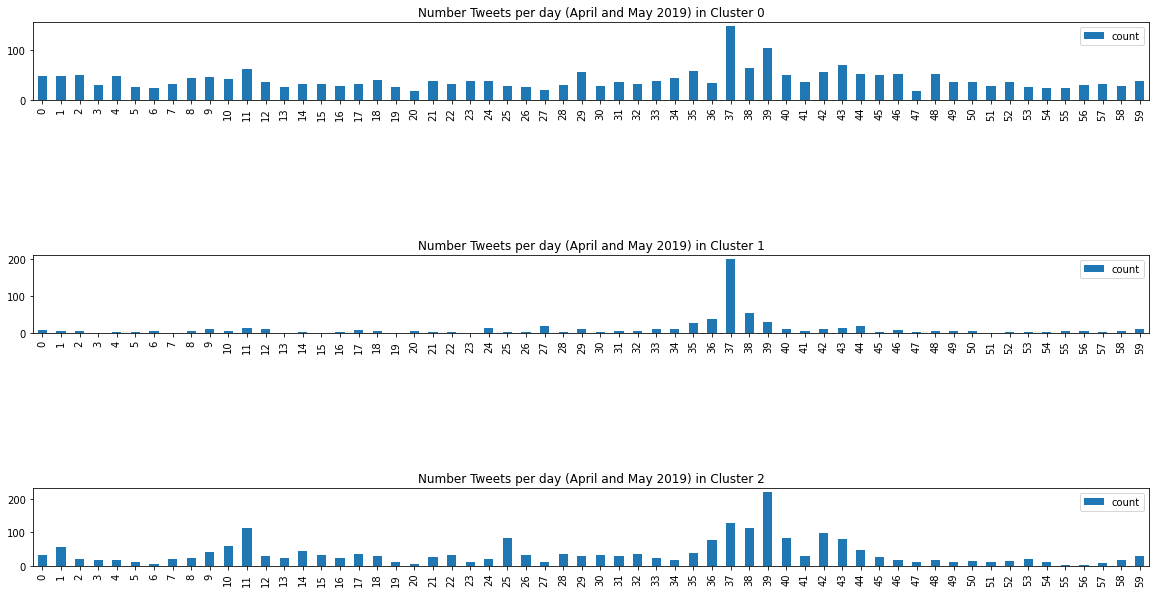

In [375]:
clusters = [tweets_cluster0, tweets_cluster1, tweets_cluster2]

import matplotlib.pyplot as plt
fig, axes =  plt.subplots(3,1, figsize=(20, 10))
plt.subplots_adjust(hspace=2)
i = 0
for c in clusters:
    dates_to_n_tweets = {}
    for t in c:
        date = t['date'].split('-')[1] + '-' + t['date'].split('-')[2]
        try:
            dates_to_n_tweets[date] = dates_to_n_tweets[date] + 1
        except:
            dates_to_n_tweets[date] = 0

    sorted_dates = sorted(dates_to_n_tweets.items())
    df = pd.DataFrame({'date': [e[0] for e in sorted_dates], 'count': [e[1] for e in sorted_dates]})
    df.plot(ax=axes[i], kind='bar', title='Number Tweets per day (April and May 2019) in Cluster %d' % i)
    i+=1
plt.show()